<a href="https://colab.research.google.com/github/CSC345DSLoveYou/HousePrice_DSLoveyou/blob/master/HousePricePredictionThree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn import linear_model


In [ ]:
print(pd.__version__)

1.1.4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dfTrain = pd.read_csv("/content/drive/Shared drives/CSC345-DS-Project/house-prices-advanced-regression-techniques/train.csv"
        , sep = ",")
print('%i subjects and %i columns' % dfTrain.shape)
dfTrain.head()

1460 subjects and 81 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
dfTest = pd.read_csv("/content/drive/Shared drives/CSC345-DS-Project/house-prices-advanced-regression-techniques/test.csv"
        , sep = ",")
print('%i subjects and %i columns' % dfTest.shape)
dfTest.head()

1459 subjects and 80 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
print("Shape of train: ", dfTrain.shape)
print("Shape of test: ", dfTest.shape)

Shape of train:  (1460, 81)
Shape of test:  (1459, 80)


In [ ]:

# making copies of train and test

#Save the 'Id' column
train_ID = dfTrain['Id']
test_ID = dfTest['Id']

# #Now drop the  'Id' colum since it's unnecessary for  the prediction process.
# dfTrain.drop("Id", axis = 1, inplace = True)
# dfTest.drop("Id", axis = 1, inplace = True)

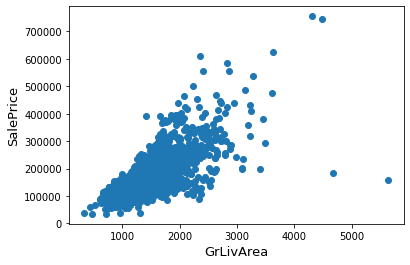

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = dfTrain['GrLivArea'], y = dfTrain['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

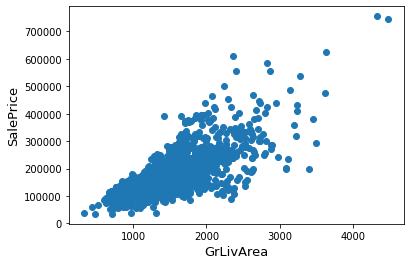

In [ ]:
#Deleting outliers
dfTrain = dfTrain.drop(dfTrain[(dfTrain['GrLivArea']>4000) & (dfTrain['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(dfTrain['GrLivArea'], dfTrain['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [ ]:
# combining the train and test datasets for preprocessing

ntrain = dfTrain.shape[0]
ntest =  dfTest.shape[0]

# creating y-train
y_train = dfTrain.SalePrice.values

combine = pd.concat([dfTrain, dfTest])
combine.drop(['SalePrice'], axis = 1, inplace =  True)

# printing the shape of new dataset
combine.shape

(2917, 80)

In [ ]:
combine_na = (combine.isnull().sum() / len(combine)) * 100
combine_na = combine_na.drop(combine_na[combine_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :combine_na})
missing_data.head(20)


,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageYrBlt,5.450806
GarageQual,5.450806
GarageCond,5.450806


In [ ]:
# checking is there are any NULL values in the train and test sets
combine.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      486
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [ ]:
# Let us see the columns that contain NaNs
def missing_values():
    temp_dict = dict()
    for i in combine.columns:
        if combine[i].isnull().sum() > 0: 
            temp_dict[i] = combine[i].isnull().sum()
    return temp_dict
            
# missing features and number of NaN in the features 

#missing_values()

# Few columns/decorations have more than 50% of the data points missing, we will discard those columns.
# uncomment the missing_values() functions called above to look them in detail.

In [ ]:
# Deleting the columns which has more than 50% of the missing values
# def delete_columns(col):
#     if combine[col].isnull().sum() > combine[col].count()/2:
#         del combine[col]
# for col in combine.columns:
#     delete_columns(col)
# let us now look at the columns that still have missing values/NaNs
missing_values()

{'Alley': 2719,
 'BsmtCond': 82,
 'BsmtExposure': 82,
 'BsmtFinSF1': 1,
 'BsmtFinSF2': 1,
 'BsmtFinType1': 79,
 'BsmtFinType2': 80,
 'BsmtFullBath': 2,
 'BsmtHalfBath': 2,
 'BsmtQual': 81,
 'BsmtUnfSF': 1,
 'Electrical': 1,
 'Exterior1st': 1,
 'Exterior2nd': 1,
 'Fence': 2346,
 'FireplaceQu': 1420,
 'Functional': 2,
 'GarageArea': 1,
 'GarageCars': 1,
 'GarageCond': 159,
 'GarageFinish': 159,
 'GarageQual': 159,
 'GarageType': 157,
 'GarageYrBlt': 159,
 'KitchenQual': 1,
 'LotFrontage': 486,
 'MSZoning': 4,
 'MasVnrArea': 23,
 'MasVnrType': 24,
 'MiscFeature': 2812,
 'PoolQC': 2908,
 'SaleType': 1,
 'TotalBsmtSF': 1,
 'Utilities': 2}

In [ ]:
# ## filling the missing values in the Column Types of BsmtFinSF2

# simply filling the NULL value with none
combine['BsmtFinSF2'].fillna(0, inplace = True)

# checking if there are any Null values left
combine['BsmtFinSF2'].isnull().any()

False

In [ ]:
# ## filling the missing values in the Column Types of BsmtFinSF1

# simply filling the NULL value with none
combine['BsmtFinSF1'].fillna(0, inplace = True)

# checking if there are any Null values left
combine['BsmtFinSF1'].isnull().any()

False

In [ ]:
# ## filling the missing values in the Column Types of BsmtFinType2

# simply filling the NULL value with none
combine['BsmtFinType2'].fillna('None', inplace = True)

# checking if there are any Null values left
combine['BsmtFinType2'].isnull().any()

False

In [ ]:
# ## filling the missing values in the Column Types of BsmtFinType1

# simply filling the NULL value with none
combine['BsmtFinType1'].fillna('None', inplace = True)

# checking if there are any Null values left
combine['BsmtFinType1'].isnull().any()

False

In [ ]:
# ## filling the missing values in the Column Types of BsmtFullBath

# simply filling the NULL value with 0 as it is the most common
combine['BsmtFullBath'].fillna(0, inplace = True)

# checking if there are any Null values left
combine['BsmtFullBath'].isnull().any()

False

In [ ]:
# ## filling the missing values in the Column Types of BsmtHalfBath

# simply filling the NULL value with 0 as it is the most common
combine['BsmtHalfBath'].fillna(0, inplace = True)

# checking if there are any Null values left
combine['BsmtHalfBath'].isnull().any()

False

In [ ]:
# ## filling the missing values in the Column Types of BsmtQual

# simply filling the NULL value with none
combine['BsmtQual'].fillna('None', inplace = True)

# checking if there are any Null values left
combine['BsmtQual'].isnull().any()

False

In [ ]:
# ## filling the missing values in the Column Types of BsmtUnfSF

# simply filling the NULL value with 0 as it is the most common
combine['BsmtUnfSF'].fillna(0, inplace = True)

# checking if there are any Null values left
combine['BsmtUnfSF'].isnull().any()

False

In [ ]:
## filling the missing values in the Column Types of Electrical

# simply filling the NULL value with VinylSd as it is the most common
combine['Electrical'].fillna(combine['Electrical'].mode()[0], inplace = True)

# checking if there are any Null values left
combine['Electrical'].isnull().any()

False

In [ ]:
## filling the missing values in the Column Types of Exterior2nd

# simply filling the NULL value with VinylSd as it is the most common
combine['Exterior1st'].fillna(combine['Exterior1st'].mode()[0], inplace = True)

# checking if there are any Null values left
combine['Exterior1st'].isnull().any()

False

In [ ]:
## filling the missing values in the Column Types of Exterior2nd

# simply filling the NULL value with most common value
combine['Exterior2nd'].fillna(combine['Exterior2nd'].mode()[0], inplace = True)

# checking if there are any Null values left
combine['Exterior2nd'].isnull().any()

False

In [ ]:
## filling the missing values in the Column Types of Fence

# simply filling the NULL value with none
combine['Fence'].fillna('None', inplace = True)

# checking if there are any Null values left
combine['Fence'].isnull().any()

False

In [ ]:
## filling the missing values in the Column Types of FireplaceQu

# simply filling the NULL value with none
combine['FireplaceQu'].fillna('None', inplace = True)

# checking if there are any Null values left
combine['FireplaceQu'].isnull().any()

False

In [ ]:
## filling the missing values in the Column Types of MSZoning

# simply filling the NULL value with none
combine['MSZoning'].fillna('None', inplace = True)

# checking if there are any Null values left
combine['MSZoning'].isnull().any()

False

In [ ]:
## filling the missing values in the Column Types of MasVnrArea

# simply filling the NULL value with 0
combine['MasVnrArea'].fillna(0, inplace = True)

# checking if there are any Null values left
combine['MasVnrArea'].isnull().any()

False

In [ ]:
## filling the missing values in the Column Types of MasVnrType

# simply filling the NULL value with none
combine['MasVnrType'].fillna('None', inplace = True)

# checking if there are any Null values left
combine['MasVnrType'].isnull().any()

False

In [ ]:
## filling the missing values in the Column Types of MiscFeature

# simply filling the NULL value with none
combine['MiscFeature'].fillna('None', inplace = True)

# checking if there are any Null values left
combine['MiscFeature'].isnull().any()

False

In [ ]:
## filling the missing values in the Column Typesof PoolQC

# simply filling the NULL value with Ex as it is the most common
combine['PoolQC'].fillna('None', inplace = True)

# checking if there are any Null values left
combine['PoolQC'].isnull().any()

False

In [ ]:
## filling the missing values in the Column SaleType

# simply filling the NULL value with WD as it is the most common
combine['SaleType'].fillna(combine['SaleType'].mode()[0], inplace = True)

# checking if there are any Null values left
combine['SaleType'].isnull().any()

False

In [ ]:
# filling the missing values in the Column TotalBsmtSF

combine['TotalBsmtSF'].fillna(combine['TotalBsmtSF'].mean(), inplace = True)

# checking if there are any Null values left
combine['TotalBsmtSF'].isnull().any()

False

In [ ]:

# checking the unique value in the column Utlities

combine['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [ ]:
# AS, we just saw that almost all the rows have same value for Utilities we will get rid of this column

combine.drop(['Utilities'], axis = 1, inplace = True)

# checking the new shape of the dataset
combine.shape

(2917, 79)

In [ ]:
# filling the missing values in the LotFrontage column

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
combine["LotFrontage"] = combine.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# checking if there are any NULL values left in the LotFronage Column
combine['LotFrontage'].isnull().any()

False

In [ ]:
# filling the missing values 

# we will replace null values with none
combine['Alley'].fillna('None', inplace = True)

# checking if there are any NULL values left
combine['Alley'].isnull().any()

False

In [ ]:

# filling the missing values in the BsmtCond column

# we are simply filling none in the place NULL values 
combine['BsmtCond'].fillna('None', inplace = True)

# checking if there are any left NULL values
combine['BsmtCond'].isnull().any()

False

In [ ]:
# filling the missing values in the BsmtCond column

# replacing No with None
combine['BsmtExposure'].replace(('No'), ('None'), inplace = True)

# we are simply filling None in the place NULL values 
combine['BsmtExposure'].fillna('None', inplace = True)

# checking if there are any left NULL values
combine['BsmtExposure'].isnull().any()

False

In [ ]:

combine['KitchenQual'].value_counts(dropna = False)

TA     1492
Gd     1151
Ex      203
Fa       70
NaN       1
Name: KitchenQual, dtype: int64

In [ ]:
# filling the missing values in the KitchenQual column

# we are simply filling TA in the place NULL values 
combine['KitchenQual'].fillna(combine['KitchenQual'].mode()[0], inplace = True)

# checking if there are any left NULL values
combine['KitchenQual'].isnull().any()

False

In [ ]:
# filling the missing values in the GarageYrBlt column

# we are simply filling none in place of NULL values
combine['GarageYrBlt'].fillna('None', inplace = True)

# checking if there are any left NULL values
combine['GarageYrBlt'].isnull().any()

False

In [ ]:
# filling the missing values in the GarageType column

# we are simply filling none in the place NULL values 
combine['GarageType'].fillna('None', inplace = True)

# checking if there are any left NULL values
combine['GarageType'].isnull().any()

False

In [ ]:
# filling the missing values in the GarageQual column

# we are simply filling none in the place NULL values 
combine['GarageQual'].fillna('None', inplace = True)

# checking if there are any left NULL values
combine['GarageQual'].isnull().any()

False

In [ ]:
# filling the missing values in the GarageFinish column

# we are simply filling none in the place NULL values  
combine['GarageFinish'].fillna('None', inplace = True)

# checking if there are any left NULL values
combine['GarageFinish'].isnull().any()

False

In [ ]:
# filling the missing values in the GarageCond column

# we are simply filling Unf in the place NULL values 
combine['GarageCond'].fillna('None', inplace = True)

# checking if there are any left NULL values
combine['GarageCond'].isnull().any()

False

In [ ]:

# filling the missing values in the GarageCars column

# we are simply filling 0 in the place NULL values 
combine['GarageCars'].fillna(0, inplace = True)

# checking if there are any left NULL values
combine['GarageCars'].isnull().any()

False

In [ ]:
# filling the missing values in the GarageArea column

# we are simply filling 0 in the place NULL values 
combine['GarageArea'].fillna(0, inplace = True)

# checking if there are any left NULL values
combine['GarageArea'].isnull().any()

False

In [ ]:
# filling the missing values in the Functional column

combine['Functional'].fillna(combine['Functional'].mode()[0], inplace = True)

# checking if there are any left NULL values
combine['Functional'].isnull().any()

False

In [ ]:
combine.isnull().sum().sum()

0

In [ ]:
# Transforming some numerical variables that are really categorical

#MSSubClass=The building class
combine['MSSubClass'] = combine['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
combine['OverallCond'] = combine['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
combine['YrSold'] = combine['YrSold'].astype(str)
combine['MoSold'] = combine['MoSold'].astype(str)

In [ ]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lb = LabelEncoder() 
    lb.fit(list(combine[c].values)) 
    combine[c] = lb.transform(list(combine[c].values))

# shape        
print('Shape all_data: {}'.format(combine.shape))

Shape all_data: (2917, 79)


In [ ]:
# one hot encoding for all the categorical variables

combine = pd.get_dummies(combine)

# checking the head of the dataset
combine.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,...,GarageYrBlt_1993.0,GarageYrBlt_1994.0,GarageYrBlt_1995.0,GarageYrBlt_1996.0,GarageYrBlt_1997.0,GarageYrBlt_1998.0,GarageYrBlt_1999.0,GarageYrBlt_2000.0,GarageYrBlt_2001.0,GarageYrBlt_2002.0,GarageYrBlt_2003.0,GarageYrBlt_2004.0,GarageYrBlt_2005.0,GarageYrBlt_2006.0,GarageYrBlt_2007.0,GarageYrBlt_2008.0,GarageYrBlt_2009.0,GarageYrBlt_2010.0,GarageYrBlt_2207.0,GarageYrBlt_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,10,65.0,8450,1,1,3,0,7,4,2003,2003,196.0,2,4,2,4,3,2,706.0,6,0.0,150.0,856.0,0,1,856,854,0,1710,1.0,0.0,2,1,3,1,2,8,6,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,2,5,80.0,9600,1,1,3,0,6,7,1976,1976,0.0,3,4,2,4,1,0,978.0,6,0.0,284.0,1262.0,0,1,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,6,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,3,10,68.0,11250,1,1,0,0,7,4,2001,2002,162.0,2,4,2,4,2,2,486.0,6,0.0,434.0,920.0,0,1,920,866,0,1786,1.0,0.0,2,1,3,1,2,6,6,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,4,11,60.0,9550,1,1,0,0,7,4,1915,1970,0.0,3,4,4,1,3,0,216.0,6,0.0,540.0,756.0,2,1,961,756,0,1717,1.0,0.0,1,0,3,1,2,7,6,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,5,10,84.0,14260,1,1,0,0,8,4,2000,2000,350.0,2,4,2,4,0,2,655.0,6,0.0,490.0,1145.0,0,1,1145,1053,0,2198,1.0,0.0,2,1,4,1,2,9,6,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
# separating the train and test datasets

x_train = combine.iloc[:ntrain]
x_test = combine.iloc[ntrain:]

# checking the shapes of train and test datasets
print("Shape of train :", x_train.shape)
print("Shape of test :", x_test.shape)

Shape of train : (1458, 324)
Shape of test : (1459, 324)


In [ ]:
#Validation function
n_folds = 5
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    print(rmse)
    return(rmse)

In [ ]:
# LASSO MODEL
# WITH PIPELINE  and using robust scalerTO AVOID SENSITIVITY TOWARDS OUTLIERS

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import Lasso

lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 3))
lasso.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 292293052497.101, tolerance: 920745877.8054452
  positive)


Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('lasso',
                 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=3, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [ ]:

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226106285531.92896, tolerance: 759169444.156396
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210716339085.45047, tolerance: 728506723.8764642
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205358360663.5886, tolerance: 698982343.4131949
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21983863783

[27184.71851482 31141.59508617 30896.33533677 26975.27466213
 30095.81538941]

Lasso score: 29258.7478 (1813.4683)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216081973498.3748, tolerance: 724928659.4996839
  positive)


In [ ]:
reg = LinearRegression()

In [ ]:
col =['OverallQual','GrLivArea','GarageCars']

In [ ]:
reg.fit(x_train.values, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = reg.predict(x_test.values)

In [ ]:
print(y_pred)

[105471.14214706 154207.14220047 178628.47367477 ... 173775.53868484
 116153.92058182 231498.61306381]


In [ ]:
submission = pd.DataFrame({'Id':x_test['Id'],'SalePrice':y_pred})

In [ ]:
print(submission)

        Id      SalePrice
0     1461  105471.142147
1     1462  154207.142200
2     1463  178628.473675
3     1464  179824.921947
4     1465  198503.485912
...    ...            ...
1454  2915   78703.823734
1455  2916   65411.976688
1456  2917  173775.538685
1457  2918  116153.920582
1458  2919  231498.613064

[1459 rows x 2 columns]


In [ ]:
submission.to_csv('/content/drive/Shared drives/CSC345-DS-Project/output/line_reg03.csv',index=False)

In [ ]:
print(y_pred)

[105471.14214706 154207.14220047 178628.47367477 ... 173775.53868484
 116153.92058182 231498.61306381]
